# data exploration

In this notebook, I will explore several statistical properties of imput data, write several functions to preprocess image. 

First,load logfile(.csv) to see total data number and check if there is any bias in steering angle.

Secondly, load image according to log file and implement image preprocessing
Data preprocessing pipeline should be like this:
* define a funciton to load image according to record in log file
* resize image if necessary
* crop image (find a proper top/bottom thresh, no need to do it in this step since one can use crop method in keras)
* add/minus steering angle according to camera type
* flip this image(these three images) and opposite corresbonding steering angle (to generate more data and fix unbalance problem in training data)  
* change image brightness to generate more training data

Finaly, do train test split, split 20% of driving log as test data. Implement a generator to generate data for training.

After all those steps, we are ready to do model training in `model.py`. 

## Step 0 explore image

Check total image number and randomly show nine images. Use their name as title.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

data_folder_name = 'data'
data_path = os.path.join(os.getcwd(),data_folder_name)
image_path = os.path.join(data_path,'IMG')

total_image_list = os.listdir(image_path)
print('total image number is ',len(total_image_list))
test_image = mpimg.imread(os.path.join(image_path,total_image_list[0]))
imshape = test_image.shape
print('shape of each image is ',imshape)

total image number is  24108
shape of each image is  (160, 320, 3)


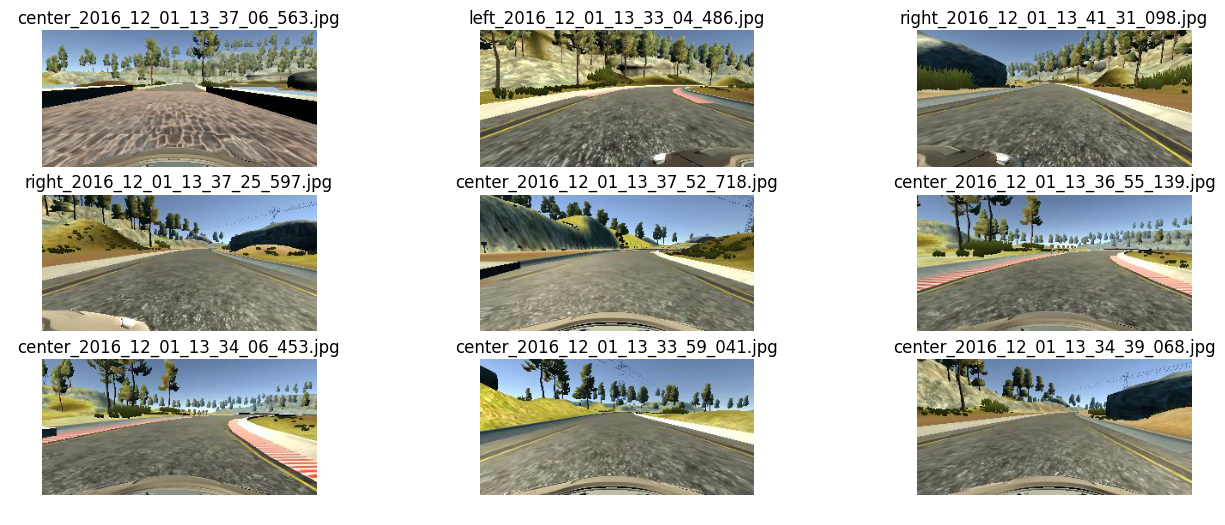

In [2]:
num_images = len(total_image_list)
example_list = np.random.randint(low = 0,high = num_images, size = 9)
fig = plt.figure(figsize=(16, 6)) 
for index,example_id in enumerate(example_list):
    tmp_image_name = total_image_list[example_id]
    tmp_image = mpimg.imread(os.path.join(image_path,tmp_image_name))
    plt.subplot(3,3,index+1)
    plt.imshow(tmp_image)
    plt.title(tmp_image_name)
    plt.axis('off')

In this step, we found image size in this project is 160\*320\*3, which indicates shape of input layer should be (160,320,3). Sky, trees and car bonnet are irrelevant to steering angle decision, so we need to crop all images.

## Step 1 Explore log record
Load driving_log.csv and show distribution of steering angles.

In [3]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

df = pd.read_csv(os.path.join(data_path,'driving_log.csv'), usecols=[0,1,2,3])

display(df.head())

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


First three columns of df are image type and image path, we can load read correponding images according to these records. The forth column is steering angle.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028DC5C37A20>]], dtype=object)

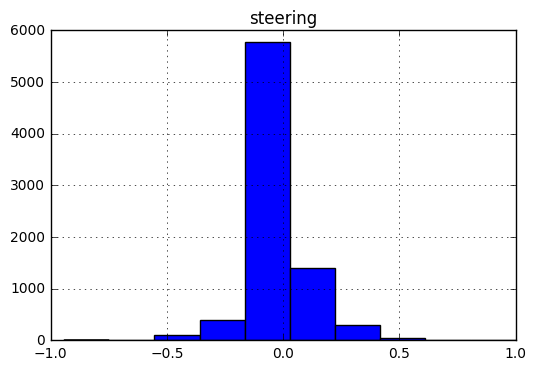

In [4]:
df.hist(column = 'steering')

Obvioursly, there are more positive steering angle in training set. So flipping image is necessary.

## Step 2 image preprocessing
In this section implement several function to preprocess image.


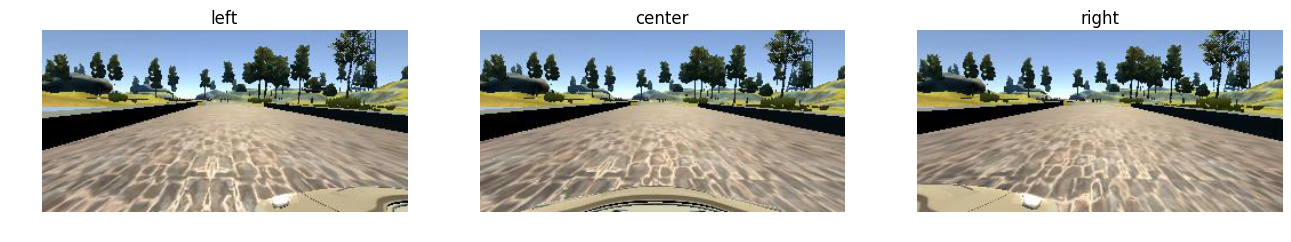

In [5]:
def load_image(img_path,log_row,camera_type):
    '''
    load specify image file in driving log
    img_path: full path of img folder
    log_df: a dataframe storing driving log
    log_id: which line in log_df I want to load
    camera_type: a string from {'center','left','right'}
    '''
    image_name = log_row[camera_type]
    image_name = image_name.split('/')[1]
    #print(image_name)
    image = mpimg.imread(os.path.join(img_path,image_name))
    return image

log_id = 1
fig = plt.figure(figsize=(16, 6)) 
for index,camera_type in enumerate(['left', 'center', 'right']):
    image = load_image(image_path,df.iloc[log_id],camera_type)
    plt.subplot(1, 3, index+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera_type)

find proper cropping parameter

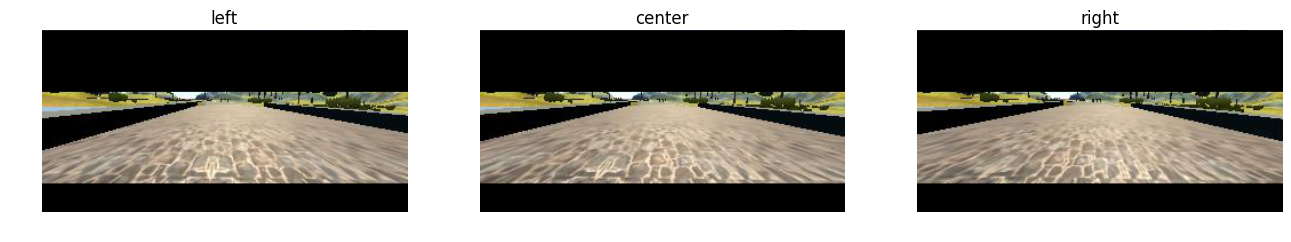

In [7]:
def crop_image(image,top,bottom):
    '''
    set pixel above 'top' or bellow 'bottom' as zero
    image: an ndarray, 160*300*3
    top: an integer < bottom
    bottom: an integer < 160
    '''
    image[1:top,:,:] = 0
    image[bottom:,:,:] = 0
    return image

top = 55
bottom = 160 - 25

log_id = 1
fig = plt.figure(figsize=(16, 6)) 
for index,camera_type in enumerate(['left', 'center', 'right']):
    image = load_image(image_path,df.iloc[log_id],camera_type)
    image = crop_image(image,top,bottom)
    plt.subplot(1, 3, index+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(camera_type)

In [8]:
### flip images to fix unbalance steering angle
import cv2

def flip_image(image,steering_angle):
    '''
    flip image and return an opposite steering angle
    '''
    image_flip = cv2.flip(image,flipCode = 1)
    return image_flip, -steering_angle
    
### resize image only when my compute cannot handle the large image

#from scipy.misc import imresize
def resize_image(image,new_dim):
    '''
    resize image to new_dim
    new_dim: a tuple
    '''
    return cv2.resize(image, new_dim)

### corrct steering angle for 'left', 'right' camera
correction = 0.23
def correct_steering(steering_angle,camera_type,correction):
    '''
    add a small number to steering angle for an image taken from left camera
    minus a small number for image taken from right camera
    '''
    if camera_type == 'left':
        return steering_angle+correction
    elif camera_type == 'right':
        return steering_angle-correction
    else:
        return steering_angle


### slightly change brightness of raw image should not change steering angle    
def tune_brightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 0.3+np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_bright
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

For each row in driving log, we can generate the following images, so that final data set used for training will be 2 times larger. 

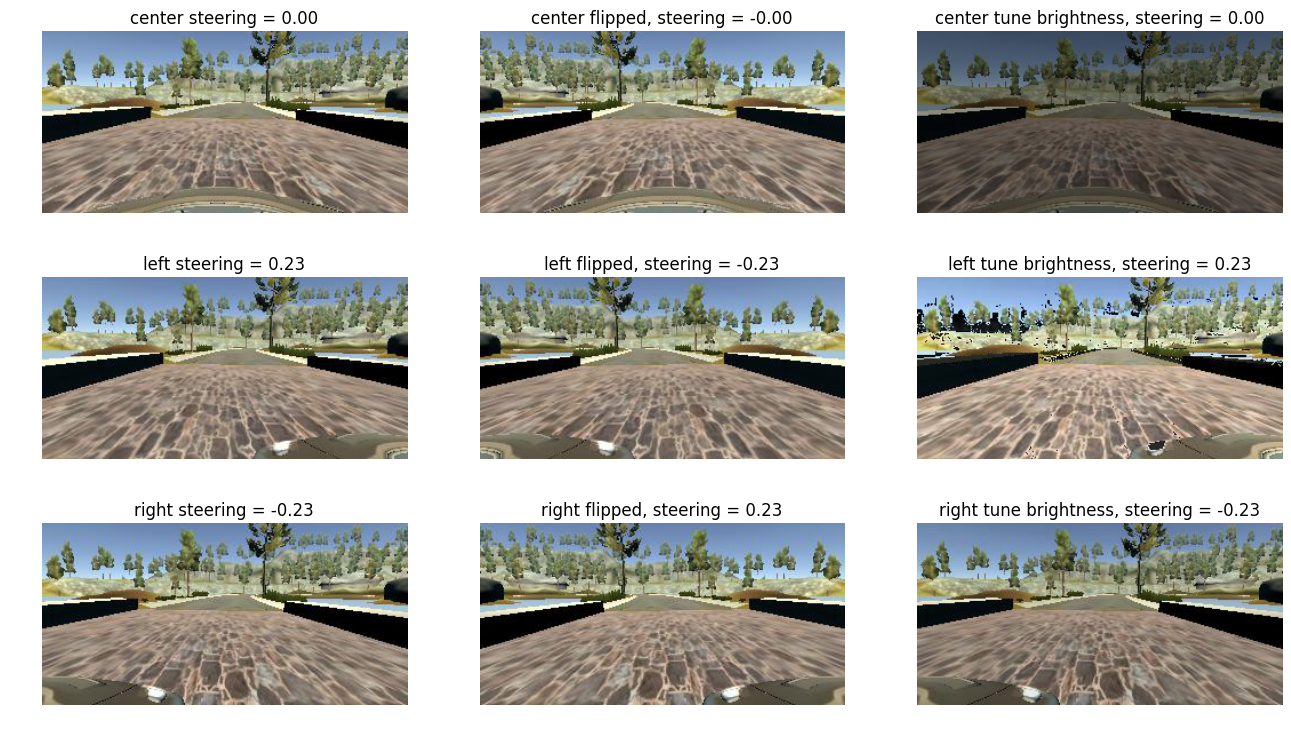

In [11]:
log_id = 3500
fig = plt.figure(figsize=(16, 9)) 
steering_raw = df.iloc[log_id]['steering']
for index,camera_type in enumerate(['center', 'left', 'right']):
    image_tmp = load_image(image_path,df.iloc[log_id],camera_type)
    steering_tmp = correct_steering(steering_raw,camera_type,correction)
    plt.subplot(3, 3, 3*index+1)
    plt.imshow(image_tmp)
    plt.axis('off')
    plt.title(camera_type+' steering = %.2f'%(steering_tmp))
    
    ### when preprocessing images, one can randomly choose to flip image or not
    [image_flip,steering_flip] = flip_image(image_tmp,steering_tmp)
    plt.subplot(3,3,3*index+2)
    plt.imshow(image_flip)
    plt.axis('off')
    plt.title(camera_type+' flipped, steering = %.2f'%(steering_flip))
    
    ### randomly tune brightness
    image_bright = tune_brightness(image_tmp)
    plt.subplot(3,3,3*index+3)
    plt.imshow(image_bright)
    plt.axis('off')
    plt.title(camera_type+' tune brightness, steering = %.2f'%(steering_tmp))

##  Step 3 train_test_split

Split dataframe 'df' into training samples and validation samples. Implement a generator to generate a batch of data.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
training_samples, validation_samples = train_test_split(df, test_size=0.2)
print(training_samples.shape)
print(validation_samples.shape)

(6428, 4)
(1608, 4)


In [13]:
display(training_samples.head())

,center,left,right,steering
1526,IMG/center_2016_12_01_13_35_12_939.jpg,IMG/left_2016_12_01_13_35_12_939.jpg,IMG/right_2016_12_01_13_35_12_939.jpg,0.186151
7079,IMG/center_2016_12_01_13_45_04_794.jpg,IMG/left_2016_12_01_13_45_04_794.jpg,IMG/right_2016_12_01_13_45_04_794.jpg,0.000000
5924,IMG/center_2016_12_01_13_43_07_623.jpg,IMG/left_2016_12_01_13_43_07_623.jpg,IMG/right_2016_12_01_13_43_07_623.jpg,0.000000
7223,IMG/center_2016_12_01_13_45_19_382.jpg,IMG/left_2016_12_01_13_45_19_382.jpg,IMG/right_2016_12_01_13_45_19_382.jpg,-0.164195
6078,IMG/center_2016_12_01_13_43_23_223.jpg,IMG/left_2016_12_01_13_43_23_223.jpg,IMG/right_2016_12_01_13_43_23_223.jpg,0.000000


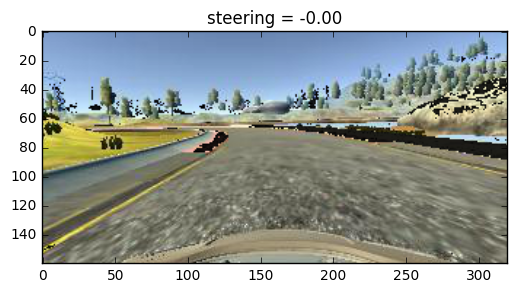

In [14]:
def get_next_image(image_path,sample_row):
    '''
    get one of the three image in specific row of sample data frame
    smaple_df can be training_sample, or validation sample
    '''
    steering_angle = sample_row['steering']
    camera_type = np.random.choice(['center', 'left', 'right'])

    steering_angle = correct_steering(steering_angle,camera_type,correction = 0.23)
    image = load_image(image_path,sample_row,camera_type)

    flip_prob = np.random.random()
    if flip_prob > 0.5:
        image,steering_angle = flip_image(image,steering_angle)
    
    image = tune_brightness(image)

    return image,steering_angle

image_tmp,angle_tmp = get_next_image(image_path,training_samples.iloc[1])
plt.imshow(image_tmp)
plt.title('steering = %.2f'%(angle_tmp))

In [15]:
def batch_generator(samples, batch_size=64):
    '''
    randomly pick 64 images as training/validation data
    samples can be training_samples, or validation samples
    '''
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            images = []
            angles = []
            for sample_id in range(batch_size):
                image_tmp,angle_tmp = get_next_image(image_path,batch_samples.iloc[sample_id])
                images.append(image_tmp)
                angles.append(angle_tmp)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train,y_train

In [16]:
train_generator = batch_generator(training_samples, batch_size=32)
validation_generator = batch_generator(validation_samples, batch_size=32)

## Step 4 build model and training

Build a simple model using keras. Check how it performs on validation set.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Activation,Dropout
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D

def get_model():
    '''
    bulid model in Nvidia's paper, with keras
    '''
    model = Sequential()
    
    # normalization and cropping 
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((55,25), (0,0))))

    # starts with five convolutional and maxpooling layers
    model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(1, 1)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))

    model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2))

    model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.4))

    model.add(Flatten())

    # Next, five fully connected layers
    model.add(Dense(1164))
    model.add(Activation('relu'))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    return model

def LeNet():
    '''
    build a simple LeNet, to debug other code
    '''
    model = Sequential()
    
    # normalization and cropping 
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((55,25), (0,0))))
    
    model.add(Convolution2D(32, 3, 3, border_mode='same', subsample=(1, 1)))
    model.add(MaxPooling2D((2, 2), border_mode='same'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model = get_model()
#model = LeNet()
model.summary()

In [ ]:
model.fit_generator(train_generator, samples_per_epoch= len(training_samples), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                    nb_epoch = 3,verbose = 2)

In [ ]:
model.save_weights('model.h5')  # always save your weights after training or during training
    with open('model.json', 'w') as outfile:
        outfile.write(model.to_json())